# Bias in EuroSAT with NST

The EuroSAT dataset is a land-cover satellite image classification use-case on 13 spectral bands consisting on 10 classes and containing 27000 labeled and geo-referenced examples. As we will be placing ourselves in the *fairness* frame of work, we will be simplyfying our problem to a Highway/River binary classification problem, where we also know that a small percentage of images (~3\% of the whole dataset) has a certain blue-veiled property. As we will prove later, this group of images constitutes a discriminated group in the sense of the equality of odds/errors.
To identify these images, we will transform the images to the HSV color-space, and use custom thresholds in the mean of each channel to flag each image as either discriminated (blue-veiled, S=0) or not (S=1). In particular, we fix this threshold at 0.35 for the saturation channel, 0.4 for the value, and verify that the hue's value is between 210 and 270. With this information, we can calculate some statistics about the dataset.

## IMPORTS

In [1]:
# General Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Pytorch and Torchvision Imports
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Augmentare Imports
import cnn_model
from simu_eva import simulation_simple, simulation_double, evaluate_simple_in_test_set, evaluate_double_in_test_set
from utils import plot_wrong_pred, plot_bar_err_rate, plot_loss_acc_train,\
                plot_bar_acc_simu_simple, plot_err_rate_simu_simple,\
                plot_bar_acc_simu_double, plot_err_rate_simu_double,\
                plot_err_rate_test, plot_acc_test, plot_err_rate_test_double,\
                plot_heatmap_accuracy, plot_heatmap_err_rate
import augmentare
from augmentare.methods.style_transfer import *
from augmentare.plots.plot_samples import plot_image
from datasets import load_dataset_filtered_eurosat

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Original Dataset

In [3]:
ds_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/data/EuroSAT"

In [4]:
# (Re)set the seeds
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

# Load the dataset
X_train, S_train, y_train, X_test, S_test, y_test = load_dataset_filtered_eurosat(path=ds_path)
print('EuroSAT dataset loaded !')
print('Training dataset (X,S,Y) : {} {} {}'.format(X_train.shape, S_train.shape, y_train.shape))
print('Testing dataset  (X,S,Y) : {} {} {}'.format(X_test.shape, S_test.shape, y_test.shape))

EuroSAT dataset loaded !
Training dataset (X,S,Y) : (3750, 3, 64, 64) (3750,) (3750,)
Testing dataset  (X,S,Y) : (1250, 3, 64, 64) (1250,) (1250,)


In [5]:
highway_images = X_train[np.where(y_train==0)]
highway_labels = y_train[np.where(y_train==0)]

blue_highway_images = X_train[np.where((S_train==0) & (y_train==0))]
blue_highway_labels = y_train[np.where((S_train==0) & (y_train==0))]

river_images = X_train[np.where(y_train==1)]
river_labels = y_train[np.where(y_train==1)]

blue_river_images = X_train[np.where((S_train==0) & (y_train==1))]
blue_river_labels = y_train[np.where((S_train==0) & (y_train==1))]

In [6]:
X_train = torch.from_numpy(X_train)
S_train = torch.from_numpy(S_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
S_test = torch.from_numpy(S_test)
y_test = torch.from_numpy(y_test)

In [7]:
train_dataset = data.TensorDataset(X_train, y_train, S_train)
train_dataloader = data.DataLoader(train_dataset, batch_size=56, shuffle=True)

test_dataset = data.TensorDataset(X_test, y_test, S_test)
test_dataloader = data.DataLoader(test_dataset, batch_size=56, shuffle=False)

In [ ]:
save_folder_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/Flow/ResNet18"

## NST

### DATA LOADING AND PREPROCESSING
Here we will divide the images into 4 categories as normal highway images, blue highway images, normal river images, blue river images. We normalize these images for the best training. 

In [8]:
transformations = transforms.Compose([
    transforms.Resize(512)
])

In [9]:
highway_images = torch.from_numpy(highway_images).float()
highway_images = transformations(highway_images)
highway_labels = torch.from_numpy(highway_labels).float()

blue_highway_images = torch.from_numpy(blue_highway_images).float()
blue_highway_images = transformations(blue_highway_images)
blue_highway_labels = torch.from_numpy(blue_highway_labels).float()

river_images = torch.from_numpy(river_images).float()
river_images = transformations(river_images)
river_labels = torch.from_numpy(river_labels).float()

blue_river_images = torch.from_numpy(blue_river_images).float()
blue_river_images = transformations(blue_river_images)
blue_river_labels = torch.from_numpy(blue_river_labels).float()

### Style Flow

In [10]:
torch.cuda.empty_cache()

In [11]:
trans = transforms.Compose([transforms.Resize((300,400))])

In [ ]:
indices_bl_rv = torch.tensor([5,6,7,8,11,12,14,16,17,19,20,21,22,24,28,29,30,31,32,36,37,40,41,45,50,52,57,59,60,63,64,65,69,70,71,73,75,77,78,79])
blue_river_images_flow = torch.index_select(blue_river_images, 0, indices_bl_rv)

In [12]:
highway_images_flow = trans(highway_images[torch.randint(len(highway_images), (len(blue_highway_images),))])
blue_highway_images_flow = trans(blue_highway_images)

river_images_flow = trans(river_images[torch.randint(len(river_images), (len(blue_river_images_flow),))])
blue_river_images_flow = trans(blue_river_images_flow)

In [13]:
hw_train_dataset = data.TensorDataset(highway_images_flow, blue_highway_images_flow)

rv_train_dataset = data.TensorDataset(river_images_flow, blue_river_images_flow)

In [14]:
from torch.utils.data.sampler import Sampler

class DistributedGivenIterationSampler(Sampler):
    def __init__(self, dataset, total_iter, batch_size, world_size=None, rank=None, last_iter=-1):
        self.dataset = dataset
        self.total_iter = total_iter
        self.batch_size = batch_size
        self.world_size = world_size
        self.rank = rank
        self.last_iter = last_iter

        self.total_size = self.total_iter*self.batch_size

        self.indices = self.gen_new_list()
        self.call = 0

    def __iter__(self):
        if self.call == 0:
            self.call = 1
            return iter(self.indices[(self.last_iter+1)*self.batch_size:])
        else:
            raise RuntimeError("this sampler is not designed to be called more than once!!")

    def gen_new_list(self):

        # each process shuffle all list with same seed, and pick one piece according to rank
        np.random.seed(0)

        all_size = self.total_size * self.world_size
        indices = np.arange(len(self.dataset))
        indices = indices[:all_size]
        num_repeat = (all_size-1) // indices.shape[0] + 1
        indices = np.tile(indices, num_repeat)
        indices = indices[:all_size]

        np.random.shuffle(indices)
        beg = self.total_size * self.rank
        indices = indices[beg:beg+self.total_size]
        #print('len: ',len(indices))
        #print('total: ',self.total_size)
        assert len(indices) == self.total_size

        return indices

    def __len__(self):
        # note here we do not take last iter into consideration, since __len__
        # should only be used for displaying, the correct remaining size is
        # handled by dataloader
        #return self.total_size - (self.last_iter+1)*self.batch_size
        return self.total_size

In [15]:
hw_train_sampler = DistributedGivenIterationSampler(hw_train_dataset,
        5000, 1, world_size=1, rank=0, last_iter=-1)

rv_train_sampler = DistributedGivenIterationSampler(rv_train_dataset,
        5000, 1, world_size=1, rank=0, last_iter=-1)

In [16]:
hw_train_loader = data.DataLoader(
        hw_train_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
        sampler=hw_train_sampler)

rv_train_loader = data.DataLoader(
        rv_train_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
        sampler=rv_train_sampler)

In [17]:
torch.cuda.empty_cache()

In [18]:
vgg_path = '/home/vuong.nguyen/vuong/augmentare/augmentare/methods/style_transfer/model/vgg_normalised_flow.pth'

In [ ]:
gen_bl_hw_func = StyleflowGenerate(hw_train_loader, device)

gen_blue_highway = gen_bl_hw_func(
    dataset=highway_images, style_img=blue_highway_images[15],
    number_img=1500, vgg_path=vgg_path
)

In [ ]:
gen_bl_rv_func = StyleflowGenerate(rv_train_loader, device)

gen_blue_river = gen_bl_rv_func(
    dataset=river_images, style_img=blue_river_images[22],
    number_img=1500, vgg_path=vgg_path
)

In [2]:
torch.save(gen_blue_highway, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/Flow/flow_bl_hw.pt")
torch.save(gen_blue_river, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/Flow/flow_bl_rv.pt")

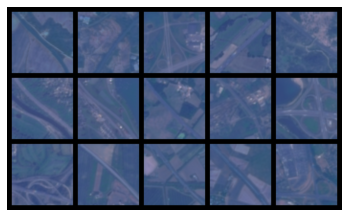

In [3]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_highway[:15], nrow=5, padding=20)
plt.figure(figsize=(6,9))
plt.imshow(Grid_hw.permute(1,2,0))
plt.axis('off')
plt.show()

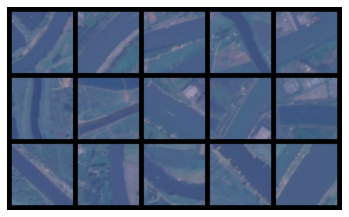

In [4]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_river[:15], nrow=5, padding=20)
plt.figure(figsize=(6,9))
plt.imshow(Grid_hw.permute(1,2,0))
plt.axis('off')
plt.show()

In [23]:
trans = transforms.Compose([
    transforms.Resize(64)
])

In [24]:
gen_blue_highway = torch.stack(gen_blue_highway).float()
gen_blue_river = torch.stack(gen_blue_river).float()

In [25]:
img_list_blue_highway = trans(gen_blue_highway)
img_list_blue_river = trans(gen_blue_river)

In [26]:
# Original dataset + blue highway images from FDA
new_X_train_1 = torch.cat((X_train, img_list_blue_highway[torch.randint(len(img_list_blue_highway), (250,))]), 0)
new_S_train_1 = torch.cat((S_train, torch.zeros(250)), 0)
new_y_train_1 = torch.cat((y_train, torch.zeros(250).long()), 0)

# Original dataset + blue river images from FDA
new_X_train_2 = torch.cat((X_train, img_list_blue_river[torch.randint(len(img_list_blue_river), (250,))]), 0)
new_S_train_2 = torch.cat((S_train, torch.zeros(250)), 0)
new_y_train_2 = torch.cat((y_train, torch.ones(250).long()), 0)

# Original dataset + blue highway and river images from FDA
new_X_train_3 = torch.cat((X_train, img_list_blue_highway[torch.randint(len(img_list_blue_highway), (1000,))], img_list_blue_river[torch.randint(len(img_list_blue_river), (900,))]), 0)
new_S_train_3 = torch.cat((S_train, torch.zeros(1000), torch.zeros(900)), 0)
new_y_train_3 = torch.cat((y_train, torch.zeros(1000).long(), torch.ones(900).long()), 0)

In [27]:
train_dataset_1 = data.TensorDataset(new_X_train_1, new_y_train_1, new_S_train_1)
train_dataloader_1 = data.DataLoader(train_dataset_1, batch_size=56, shuffle=True)

train_dataset_2 = data.TensorDataset(new_X_train_2, new_y_train_2, new_S_train_2)
train_dataloader_2 = data.DataLoader(train_dataset_2, batch_size=56, shuffle=True)

train_dataset_3 = data.TensorDataset(new_X_train_3, new_y_train_3, new_S_train_3)
train_dataloader_3 = data.DataLoader(train_dataset_3, batch_size=56, shuffle=True)

### ResNet-18

#### Blue highway

In [28]:
new_model_1 = cnn_model.ResNet18(device=device)

In [29]:
model_hw_path = save_folder_path + '/' + 'model_hw.pt'

train_acc_1, train_losses_1, val_acc_1, val_losses_1 = new_model_1.train(
    train_loader=train_dataloader_1, valid_loader=test_dataloader,
    learning_rate=0.00008, num_epochs=500, save_path= model_hw_path
)

Epoch [1/500], Train loss: 0.7478, Val loss: 0.7279, Train accuracy: 55.9250%, Val accuracy: 57.9200%
Validation loss decreased (inf --> 0.7279).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6548, Val loss: 0.6570, Train accuracy: 63.0750%, Val accuracy: 63.0400%
Validation loss decreased (0.7279 --> 0.6570).  Saving model ===>>>
Epoch [3/500], Train loss: 0.5938, Val loss: 0.6009, Train accuracy: 68.8000%, Val accuracy: 68.5600%
Validation loss decreased (0.6570 --> 0.6009).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5439, Val loss: 0.5705, Train accuracy: 73.8250%, Val accuracy: 70.8000%
Validation loss decreased (0.6009 --> 0.5705).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5102, Val loss: 0.5412, Train accuracy: 75.5250%, Val accuracy: 72.9600%
Validation loss decreased (0.5705 --> 0.5412).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4881, Val loss: 0.5202, Train accuracy: 78.4500%, Val accuracy: 74.8800%
Validation loss decreased (0.5412 --> 0.5202).  Sav

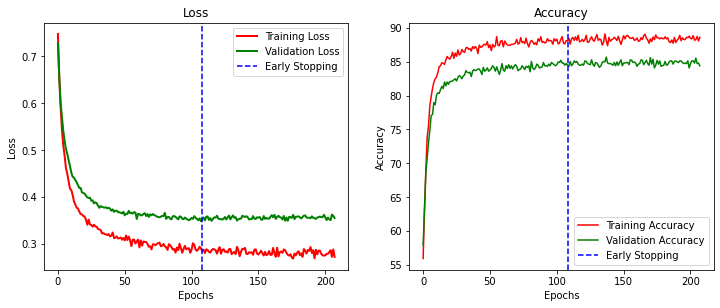

In [30]:
plot_loss_acc_train(train_losses_1, val_losses_1, train_acc_1, val_acc_1)

In [31]:
avg_loss_1, per_crr_1, dict_1, err_rate_1 = new_model_1.test(test_loader=test_dataloader, test_gobal=True)

Test loss: 0.3481, Accuracy: 84.7200%, Error rate of blue images: 12.0419%


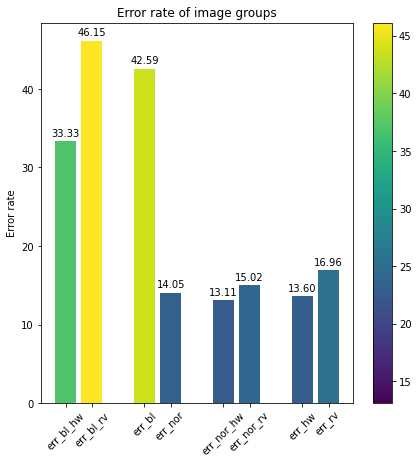

In [32]:
plot_bar_err_rate(err_rate_1)

In [33]:
torch.cuda.empty_cache()

In [34]:
# Original dataset + blue highway images from FDA
nb_blue_highway = [0, 250, 500, 750, 1000, 1250]
global_accuracy_1, highway_accuracy_1, blue_highway_accuracy_1, river_accuracy_1, blue_river_accuracy_1=simulation_simple(
    num_epochs=500, valid_loader=test_dataloader,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images=img_list_blue_highway, nb_new_images=nb_blue_highway,
    device=device, save_folder_path=save_folder_path, type='blue_highway'
)

Epoch [1/500], Train loss: 0.7303, Val loss: 0.6787, Train accuracy: 55.9467%, Val accuracy: 60.1600%
Validation loss decreased (inf --> 0.6787).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6439, Val loss: 0.6189, Train accuracy: 63.4933%, Val accuracy: 65.0400%
Validation loss decreased (0.6787 --> 0.6189).  Saving model ===>>>
Epoch [3/500], Train loss: 0.5883, Val loss: 0.5775, Train accuracy: 69.5467%, Val accuracy: 69.6000%
Validation loss decreased (0.6189 --> 0.5775).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5430, Val loss: 0.5458, Train accuracy: 73.2800%, Val accuracy: 73.0400%
Validation loss decreased (0.5775 --> 0.5458).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5129, Val loss: 0.5190, Train accuracy: 75.9200%, Val accuracy: 73.6000%
Validation loss decreased (0.5458 --> 0.5190).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4875, Val loss: 0.4975, Train accuracy: 78.2133%, Val accuracy: 76.0800%
Validation loss decreased (0.5190 --> 0.4975).  Sav

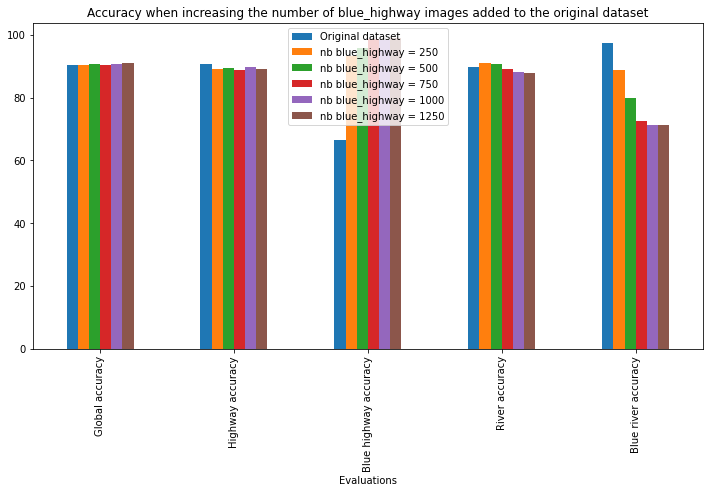

In [35]:
plot_bar_acc_simu_simple(
    global_accuracy_1,
    highway_accuracy_1,
    blue_highway_accuracy_1,
    river_accuracy_1,
    blue_river_accuracy_1,
    nb_new_images=nb_blue_highway,
    type='blue_highway'
)

#### Blue river

In [36]:
new_model_2 = cnn_model.ResNet18(device=device)

In [37]:
model_rv_path = save_folder_path + '/' + 'model_rv.pt'

train_acc_2, train_losses_2, val_acc_2, val_losses_2 = new_model_2.train(
    train_loader=train_dataloader_2, valid_loader=test_dataloader,
    learning_rate=0.00008, num_epochs=500, save_path=model_rv_path
)

Epoch [1/500], Train loss: 0.7750, Val loss: 0.7570, Train accuracy: 54.0750%, Val accuracy: 54.0800%
Validation loss decreased (inf --> 0.7570).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6763, Val loss: 0.6608, Train accuracy: 61.2750%, Val accuracy: 62.6400%
Validation loss decreased (0.7570 --> 0.6608).  Saving model ===>>>
Epoch [3/500], Train loss: 0.6054, Val loss: 0.6045, Train accuracy: 68.7750%, Val accuracy: 67.9200%
Validation loss decreased (0.6608 --> 0.6045).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5483, Val loss: 0.5612, Train accuracy: 73.1750%, Val accuracy: 71.7600%
Validation loss decreased (0.6045 --> 0.5612).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5084, Val loss: 0.5305, Train accuracy: 75.8500%, Val accuracy: 75.0400%
Validation loss decreased (0.5612 --> 0.5305).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4806, Val loss: 0.5037, Train accuracy: 78.1500%, Val accuracy: 76.4000%
Validation loss decreased (0.5305 --> 0.5037).  Sav

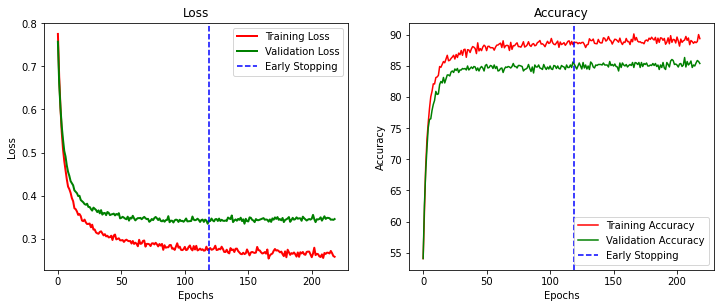

In [38]:
plot_loss_acc_train(train_losses_2, val_losses_2, train_acc_2, val_acc_2)

In [39]:
avg_loss_2, per_crr_2, dict_2, err_rate_2 = new_model_2.test(test_loader=test_dataloader, test_gobal=True)

Test loss: 0.3348, Accuracy: 85.6000%, Error rate of blue images: 7.2222%


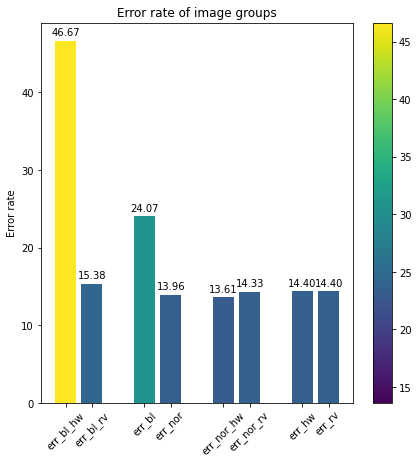

In [40]:
plot_bar_err_rate(err_rate_2)

In [41]:
torch.cuda.empty_cache()

In [42]:
# Original dataset + blue highway images from FDA
nb_blue_river = [0, 250, 500, 750, 1000, 1250]
global_accuracy_2, highway_accuracy_2, blue_highway_accuracy_2, river_accuracy_2, blue_river_accuracy_2=simulation_simple(
    num_epochs=500, valid_loader=test_dataloader,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images=img_list_blue_river, nb_new_images=nb_blue_river,
    device=device, save_folder_path=save_folder_path, type='blue_river'
)

Epoch [1/500], Train loss: 0.7837, Val loss: 0.7266, Train accuracy: 52.8267%, Val accuracy: 56.8000%
Validation loss decreased (inf --> 0.7266).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6883, Val loss: 0.6584, Train accuracy: 59.9467%, Val accuracy: 62.8800%
Validation loss decreased (0.7266 --> 0.6584).  Saving model ===>>>
Epoch [3/500], Train loss: 0.6222, Val loss: 0.6034, Train accuracy: 66.2667%, Val accuracy: 67.4400%
Validation loss decreased (0.6584 --> 0.6034).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5697, Val loss: 0.5632, Train accuracy: 70.8267%, Val accuracy: 70.8000%
Validation loss decreased (0.6034 --> 0.5632).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5238, Val loss: 0.5346, Train accuracy: 74.3733%, Val accuracy: 72.9600%
Validation loss decreased (0.5632 --> 0.5346).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4988, Val loss: 0.5104, Train accuracy: 77.6533%, Val accuracy: 74.1600%
Validation loss decreased (0.5346 --> 0.5104).  Sav

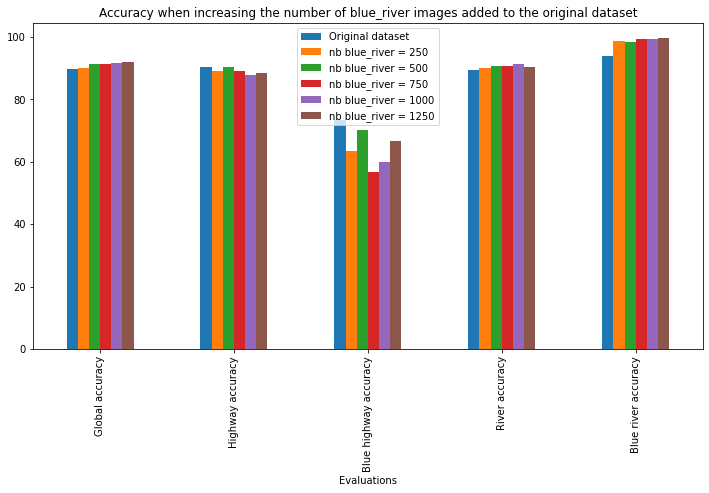

In [43]:
plot_bar_acc_simu_simple(
    global_accuracy_2,
    highway_accuracy_2,
    blue_highway_accuracy_2,
    river_accuracy_2,
    blue_river_accuracy_2,
    nb_new_images=nb_blue_river,
    type='blue_river'
)

#### All blue highway and blue river

In [44]:
new_model_3 = cnn_model.ResNet18(device=device)

In [45]:
model_hw_rv_path = save_folder_path + '/' + 'model_hw_rv.pt'

train_acc_3, train_losses_3, val_acc_3, val_losses_3 = new_model_3.train(
    train_loader=train_dataloader_3, valid_loader=test_dataloader,
    learning_rate=0.00008, num_epochs=500, save_path=model_hw_rv_path
)

Epoch [1/500], Train loss: 0.7856, Val loss: 0.7603, Train accuracy: 54.4878%, Val accuracy: 53.1200%
Validation loss decreased (inf --> 0.7603).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6310, Val loss: 0.6581, Train accuracy: 65.5772%, Val accuracy: 62.8800%
Validation loss decreased (0.7603 --> 0.6581).  Saving model ===>>>
Epoch [3/500], Train loss: 0.5434, Val loss: 0.5956, Train accuracy: 73.5122%, Val accuracy: 68.4800%
Validation loss decreased (0.6581 --> 0.5956).  Saving model ===>>>
Epoch [4/500], Train loss: 0.4857, Val loss: 0.5566, Train accuracy: 78.0813%, Val accuracy: 71.3600%
Validation loss decreased (0.5956 --> 0.5566).  Saving model ===>>>
Epoch [5/500], Train loss: 0.4431, Val loss: 0.5267, Train accuracy: 81.7886%, Val accuracy: 74.6400%
Validation loss decreased (0.5566 --> 0.5267).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4186, Val loss: 0.5068, Train accuracy: 82.4715%, Val accuracy: 75.0400%
Validation loss decreased (0.5267 --> 0.5068).  Sav

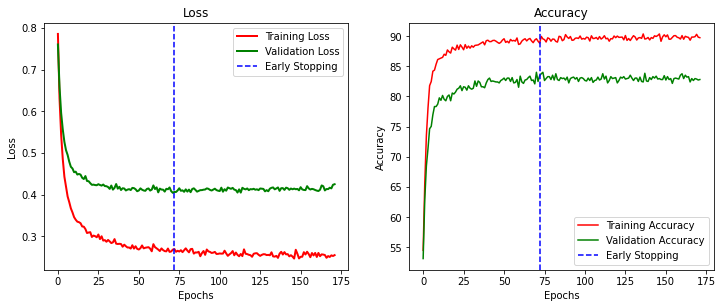

In [46]:
plot_loss_acc_train(train_losses_3, val_losses_3, train_acc_3, val_acc_3)

In [47]:
avg_loss_3, per_crr_3, dict_3, err_rate_3 = new_model_3.test(test_loader=test_dataloader, test_gobal=True)

Test loss: 0.4044, Accuracy: 82.4800%, Error rate of blue images: 10.9589%


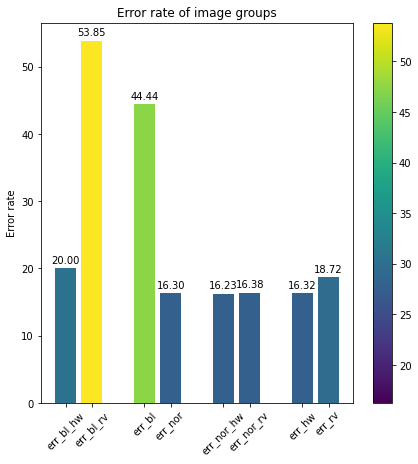

In [48]:
plot_bar_err_rate(err_rate_3)

In [49]:
torch.cuda.empty_cache()

In [50]:
nbs_blue_river   = [0, 400, 800, 1200, 400, 400]
nbs_blue_highway = [0, 400, 400, 400, 800, 1200]

per_blue_highway = []
per_blue_river = []
per_highway = []
per_river = []
total_dataset = []

for i in range(len(nbs_blue_highway)):
    total = len(X_train) + nbs_blue_highway[i] + nbs_blue_river[i]
    per_bl_hw = (len(X_train[torch.where((S_train==0) & (y_train==0))]) + nbs_blue_highway[i]) / total
    per_bl_rv = (len(X_train[torch.where((S_train==0) & (y_train==1))]) + nbs_blue_river[i]) / total
    per_hw = (len(X_train[torch.where((S_train==1) & (y_train==0))])) / total
    per_rv = (len(X_train[torch.where((S_train==1) & (y_train==1))])) / total

    per_blue_highway.append(per_bl_hw)
    per_blue_river.append(per_bl_rv)
    per_highway.append(per_hw)
    per_river.append(per_rv)
    total_dataset.append(total)

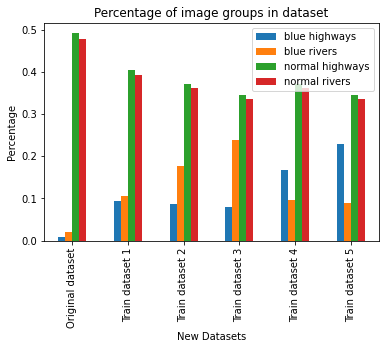

In [51]:
plotdata = pd.DataFrame({
    "blue highways": per_blue_highway,
    "blue rivers": per_blue_river,
    "normal highways": per_highway,
    "normal rivers": per_river
    },
    index=["Original dataset", "Train dataset 1", "Train dataset 2", "Train dataset 3", "Train dataset 4", "Train dataset 5"])
plotdata.plot(kind='bar')
plt.xlabel("New Datasets")
plt.ylabel("Percentage")
plt.title("Percentage of image groups in dataset")
plt.show()

In [52]:
global_accuracy_3, highway_accuracy_3, blue_highway_accuracy_3, river_accuracy_3, blue_river_accuracy_3=simulation_double(
    num_epochs=500, valid_loader=test_dataloader,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images_1=img_list_blue_highway, nb_new_images_1=nbs_blue_highway,
    new_images_2=img_list_blue_river, nb_new_images_2=nbs_blue_river,
    device=device, save_folder_path=save_folder_path,
    type_1='blue_highway', type_2='blue_river'
)

Epoch [1/500], Train loss: 0.7393, Val loss: 0.6741, Train accuracy: 55.5467%, Val accuracy: 62.1600%
Validation loss decreased (inf --> 0.6741).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6596, Val loss: 0.6191, Train accuracy: 62.1867%, Val accuracy: 66.4000%
Validation loss decreased (0.6741 --> 0.6191).  Saving model ===>>>
Epoch [3/500], Train loss: 0.5917, Val loss: 0.5707, Train accuracy: 68.2667%, Val accuracy: 70.6400%
Validation loss decreased (0.6191 --> 0.5707).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5443, Val loss: 0.5349, Train accuracy: 74.0800%, Val accuracy: 73.3600%
Validation loss decreased (0.5707 --> 0.5349).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5184, Val loss: 0.5110, Train accuracy: 74.9333%, Val accuracy: 74.4800%
Validation loss decreased (0.5349 --> 0.5110).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4904, Val loss: 0.4863, Train accuracy: 77.1733%, Val accuracy: 78.0800%
Validation loss decreased (0.5110 --> 0.4863).  Sav

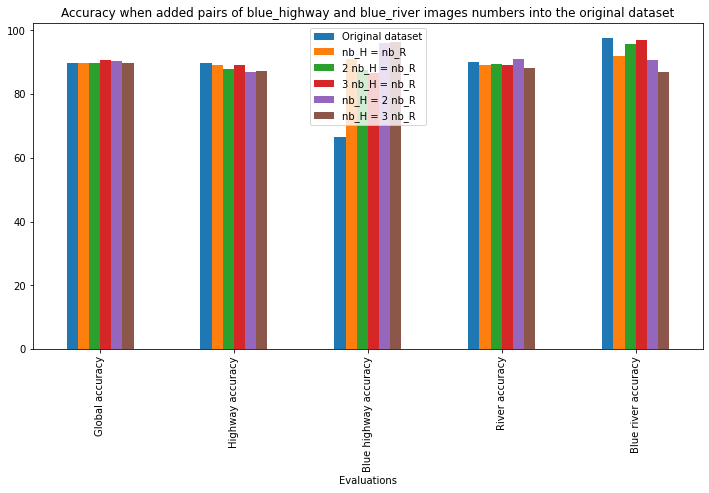

In [53]:
plot_bar_acc_simu_double(
    global_accuracy_3,
    highway_accuracy_3,
    blue_highway_accuracy_3,
    river_accuracy_3,
    blue_river_accuracy_3,
    type_1='blue_highway', type_2='blue_river'
)

#### Final

In [54]:
torch.cuda.empty_cache()

In [55]:
accuracy_test, error_rate_test = evaluate_simple_in_test_set(
    test_set=test_dataloader, num_epochs=500,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images_1=img_list_blue_highway, new_images_2=img_list_blue_river, nb_new_images_1=750,
    device=device, save_folder_path=save_folder_path,
    type_new_images_1='blue_highway', type_new_images_2='blue_river'
)

Epoch [1/500], Train loss: 0.7495, Val loss: 0.6853, Train accuracy: 53.4667%, Val accuracy: 59.2000%
Validation loss decreased (inf --> 0.6853).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6622, Val loss: 0.6254, Train accuracy: 62.0800%, Val accuracy: 64.8000%
Validation loss decreased (0.6853 --> 0.6254).  Saving model ===>>>
Epoch [3/500], Train loss: 0.6006, Val loss: 0.5789, Train accuracy: 68.1333%, Val accuracy: 70.0000%
Validation loss decreased (0.6254 --> 0.5789).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5607, Val loss: 0.5399, Train accuracy: 72.2133%, Val accuracy: 74.3200%
Validation loss decreased (0.5789 --> 0.5399).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5143, Val loss: 0.5160, Train accuracy: 76.3467%, Val accuracy: 76.0800%
Validation loss decreased (0.5399 --> 0.5160).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4929, Val loss: 0.4910, Train accuracy: 77.3600%, Val accuracy: 77.0400%
Validation loss decreased (0.5160 --> 0.4910).  Sav

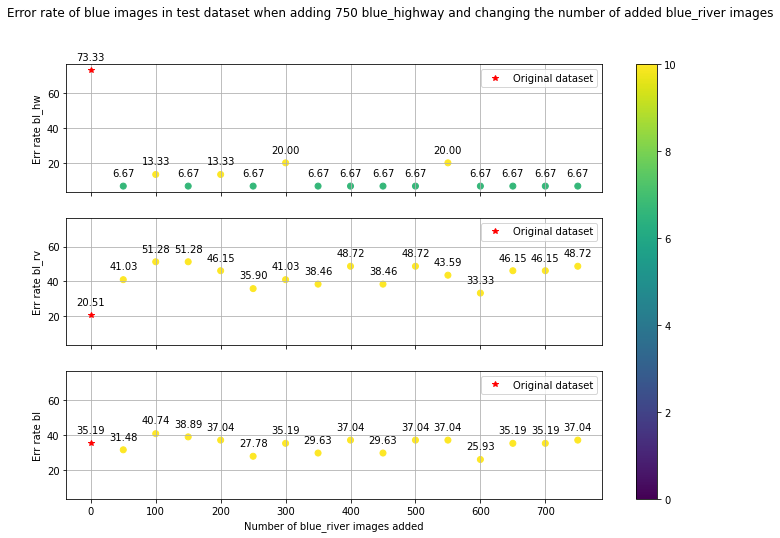

In [56]:
plot_err_rate_test(error_rate_blue_images=error_rate_test, type_new_images_1="blue_highway",
                    nb_new_images_1=750, type_new_images_2="blue_river")

In [57]:
accuracy_test_1, error_rate_test_1 = evaluate_simple_in_test_set(
    test_set=test_dataloader, num_epochs=500,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images_1=img_list_blue_river, new_images_2=img_list_blue_highway, nb_new_images_1=750,
    device=device, save_folder_path=save_folder_path,
    type_new_images_1='blue_river', type_new_images_2='blue_highway'
)

Epoch [1/500], Train loss: 0.7353, Val loss: 0.6960, Train accuracy: 56.5067%, Val accuracy: 60.8800%
Validation loss decreased (inf --> 0.6960).  Saving model ===>>>
Epoch [2/500], Train loss: 0.6532, Val loss: 0.6231, Train accuracy: 63.6000%, Val accuracy: 67.2000%
Validation loss decreased (0.6960 --> 0.6231).  Saving model ===>>>
Epoch [3/500], Train loss: 0.5830, Val loss: 0.5752, Train accuracy: 69.5200%, Val accuracy: 70.2400%
Validation loss decreased (0.6231 --> 0.5752).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5333, Val loss: 0.5384, Train accuracy: 73.7600%, Val accuracy: 73.9200%
Validation loss decreased (0.5752 --> 0.5384).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5009, Val loss: 0.5102, Train accuracy: 76.4533%, Val accuracy: 76.4000%
Validation loss decreased (0.5384 --> 0.5102).  Saving model ===>>>
Epoch [6/500], Train loss: 0.4804, Val loss: 0.4858, Train accuracy: 78.4267%, Val accuracy: 77.5200%
Validation loss decreased (0.5102 --> 0.4858).  Sav

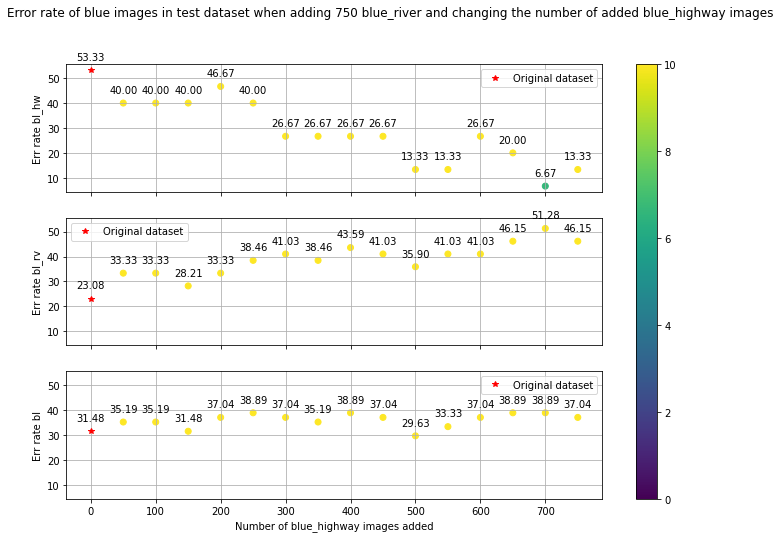

In [58]:
plot_err_rate_test(error_rate_blue_images=error_rate_test_1, type_new_images_1="blue_river",
                    nb_new_images_1=750, type_new_images_2="blue_highway")

In [59]:
nbs_highway = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
nbs_river = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [60]:
accuracy, error_rate = evaluate_double_in_test_set(
    test_set=test_dataloader, num_epochs=500,
    X_train=X_train, S_train=S_train, y_train=y_train,
    new_images_1=img_list_blue_highway, nb_new_images_1=nbs_highway,
    new_images_2=img_list_blue_river, nb_new_images_2=nbs_river,
    device=device, save_folder_path=save_folder_path,
    type_1='blue_highway', type_2='blue_river'
)

Epoch [1/500], Train loss: 0.8042, Val loss: 0.7363, Train accuracy: 52.6667%, Val accuracy: 55.6800%
Validation loss decreased (inf --> 0.7363).  Saving model ===>>>
Epoch [2/500], Train loss: 0.7113, Val loss: 0.6477, Train accuracy: 57.6533%, Val accuracy: 62.9600%
Validation loss decreased (0.7363 --> 0.6477).  Saving model ===>>>
Epoch [3/500], Train loss: 0.6398, Val loss: 0.6080, Train accuracy: 63.7333%, Val accuracy: 65.7600%
Validation loss decreased (0.6477 --> 0.6080).  Saving model ===>>>
Epoch [4/500], Train loss: 0.5870, Val loss: 0.5671, Train accuracy: 68.4533%, Val accuracy: 70.0000%
Validation loss decreased (0.6080 --> 0.5671).  Saving model ===>>>
Epoch [5/500], Train loss: 0.5406, Val loss: 0.5304, Train accuracy: 73.6267%, Val accuracy: 74.5600%
Validation loss decreased (0.5671 --> 0.5304).  Saving model ===>>>
Epoch [6/500], Train loss: 0.5069, Val loss: 0.5049, Train accuracy: 75.7867%, Val accuracy: 75.6800%
Validation loss decreased (0.5304 --> 0.5049).  Sav

In [61]:
np.save("/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/Flow/flow_accuracy.npy", accuracy)
np.save("/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/Flow/flow_err_rate.npy", error_rate)

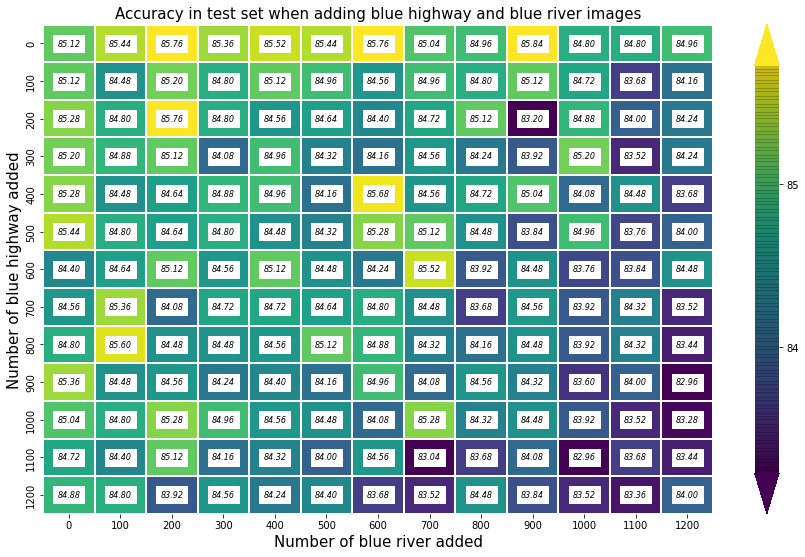

In [63]:
plot_heatmap_accuracy(accuracy, nbs_highway, nbs_river)

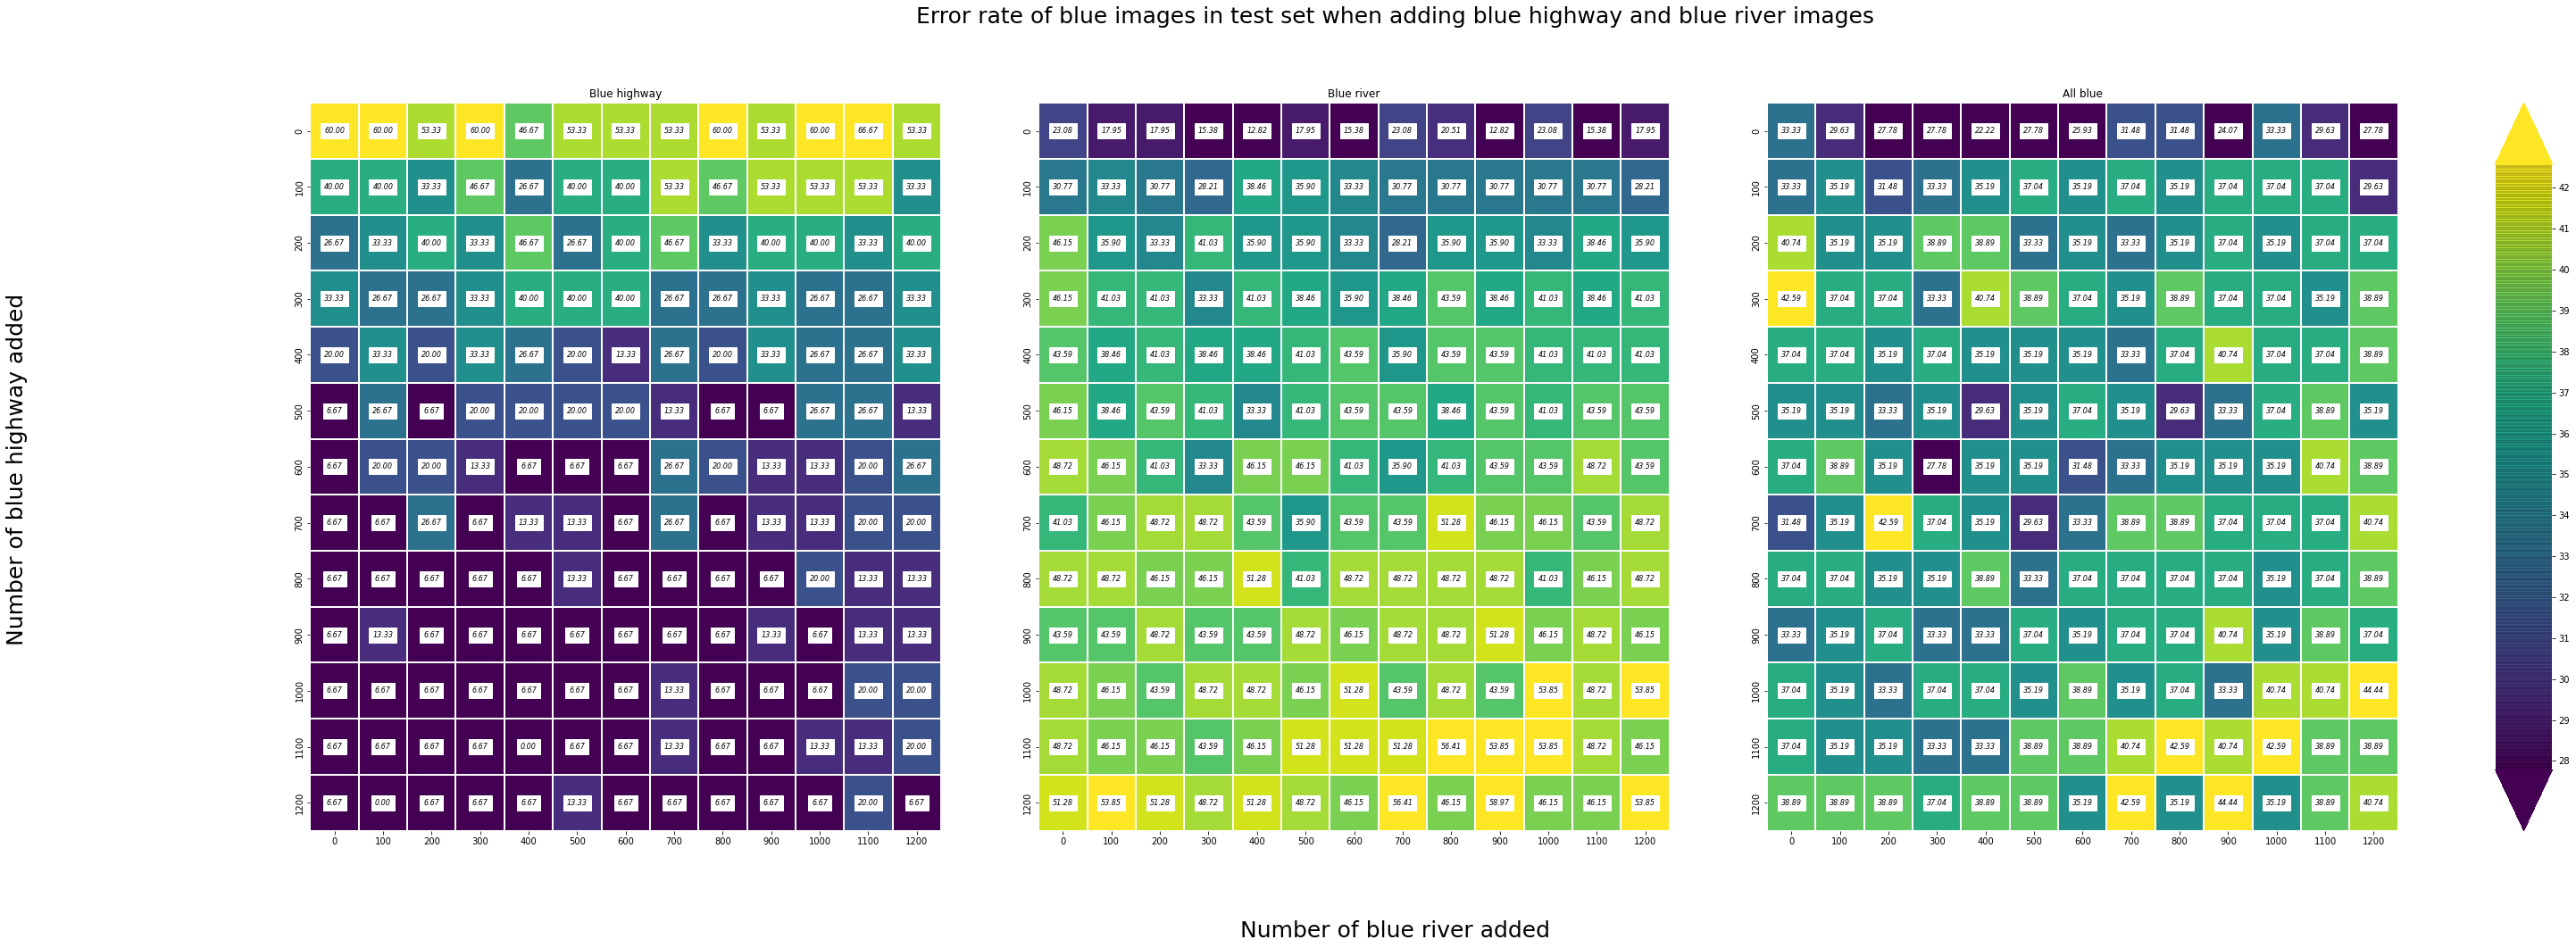

In [62]:
plot_heatmap_err_rate(error_rate, nbs_highway, nbs_river)